In [3]:

# Source for formatting: https://github.com/loicduffar/ERA5-tools
# Source ERA5: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=overview [Climate Data Store, Copernicus DOI: 10.24381/cds.adbb2d47]
# Hersbach, H., Bell, B., Berrisford, P., Biavati, G., Horányi, A., Muñoz Sabater, J., Nicolas, J., Peubey, C., Radu, R., Rozum, I., Schepers, D., Simmons, A., Soci, C., Dee, D., Thépaut, J-N. (2023): ERA5 hourly data on single levels from 1940 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS), DOI: 10.24381/cds.adbb2d47

# Source for Tidal Gauge: https://tidesandcurrents.noaa.gov/stationhome.html?id=8518750 [NOAA The Battery Station]

# Source for NYC 311 : https://data.cityofnewyork.us/Social-Services/NYC-311-Data/jrb2-thup/about_data; 311 Service Requests from 2010 to Present


### Motivation: To see if meteorological variables can be enough to predict widespread flooding risk of a major coastal city, in this case New York City. In 2012, Hurricane Sandy cost New York City an estimated $19 billion in total damages and economic opportunity costs. Resiliency projects since the storm have been ongoing, making it one of the most expensive and consequential storms in US history (https://www.nyc.gov/site/cdbgdr/hurricane-sandy/hurricane-sandy.page). What are the most important factors we should be tracking when it comes to preparing for storms? 


### Approach: First, this notebook will pull climatic data from the ERA5 dataset and tidal gauge measurements from the NYC Battery Station NOAA repository with max tidal gauge measurements as the target column. Then, I will develop a RandomForest ML model to assess whether these variables produce a successful model effective at predicting tidal gauge anomalies. If unsuccessful, then I will assess why and use the 311-NYC helpline dataset to see if the community helpline's calls related to flooding have any connection to the climatic variables. 


In [ ]:
import xarray as xr
import pandas as pd
import seaborn as sb
import cdsapi
import matplotlib.pyplot as plt

In [166]:
#Generated using Copernicus Climate Change Service information 2024 




dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": [
        "2m_dewpoint_temperature",
        "2m_temperature",
        "mean_sea_level_pressure",
        "total_precipitation",
        "surface_runoff",
        "10m_v_component_of_wind",
        "significant_height_of_combined_wind_waves_and_swell",
        "mean_period_of_total_swell"
    ],
    "year": [
        "1984", "1985", "1986",
        "1987", "1988", "1989",
        "1990", "1991", "1992",
        "1993", "1994", "1995",
        "1996", "1997", "1998",
        "1999", "2000", "2001",
        "2002", "2003", "2004",
        "2005", "2006", "2007",
        "2008", "2009", "2010",
        "2011", "2012", "2013",
        "2014", "2015", "2016",
        "2017", "2018", "2019",
        "2020", "2021", "2022",
        "2023", "2024"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [40.92, -74.27, 40.49, -73.68]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download("era5_data.nc")

2024-11-17 15:57:45,623 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-11-17 15:57:45,624 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-11-17 15:57:45,625 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-11-17 15:57:45,626 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using t

e11956e377d9e42d70c0ac9d145b4db1.zip:   0%|          | 0.00/200k [00:00<?, ?B/s]

'era5_data.nc'

In [4]:
ds = xr.open_dataset('data_1.nc')
ds0 = xr.open_dataset('data_0.nc')

In [205]:
ds

<xarray.Dataset> Size: 82kB
Dimensions:    (date: 490, latitude: 2, longitude: 3)
Coordinates:
    number     int64 8B 0
  * date       (date) int64 4kB 19840101 19840201 19840301 ... 20240901 20241001
  * latitude   (latitude) float64 16B 40.74 40.49
  * longitude  (longitude) float64 24B -74.27 -74.02 -73.77
    expver     (date) <U4 8kB '0001' '0001' '0001' ... '0001' '0005' '0005'
Data variables:
    sro        (date, latitude, longitude) float32 12kB 3.708e-05 ... 1.03e-06
    msl        (date, latitude, longitude) float32 12kB 1.022e+05 ... 1.019e+05
    v10        (date, latitude, longitude) float32 12kB -0.7039 ... -0.6069
    t2m        (date, latitude, longitude) float32 12kB 269.6 270.0 ... 289.0
    d2m        (date, latitude, longitude) float32 12kB 265.0 265.7 ... 281.6
    tp         (date, latitude, longitude) float32 12kB 0.001567 ... 0.0004215
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [18]:
ds0

<xarray.Dataset> Size: 20kB
Dimensions:    (date: 490, longitude: 2)
Coordinates:
    number     int64 8B ...
  * date       (date) int64 4kB 19840101 19840201 19840301 ... 20240901 20241001
    latitude   float64 8B ...
  * longitude  (longitude) float64 16B -74.27 -73.77
    expver     (date) <U4 8kB ...
Data variables:
    swh        (date, longitude) float32 4kB ...
    mwd        (date, longitude) float32 4kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [5]:

import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

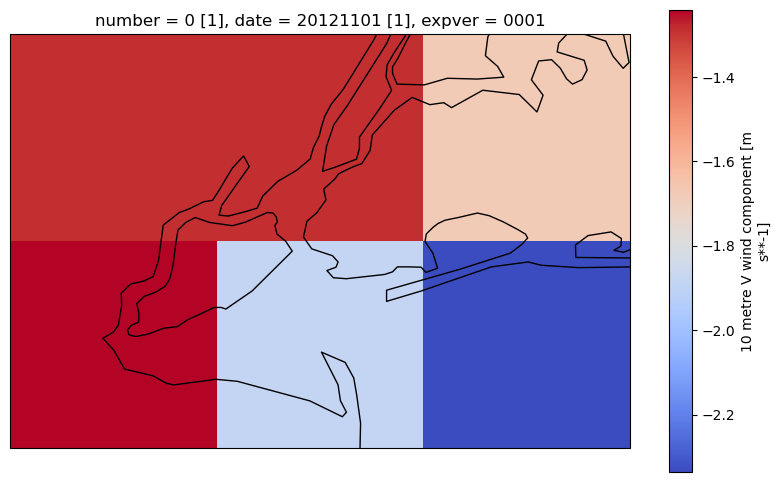

In [414]:
#sandy = 20121101

fig, ax = plt.subplots(figsize= (10,6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()


ds['v10'].isel(date=346).plot(
    ax=ax,
    x='longitude',  # Longitude coordinate
    y='latitude',  # Latitude coordinate
    cmap='coolwarm',  
)

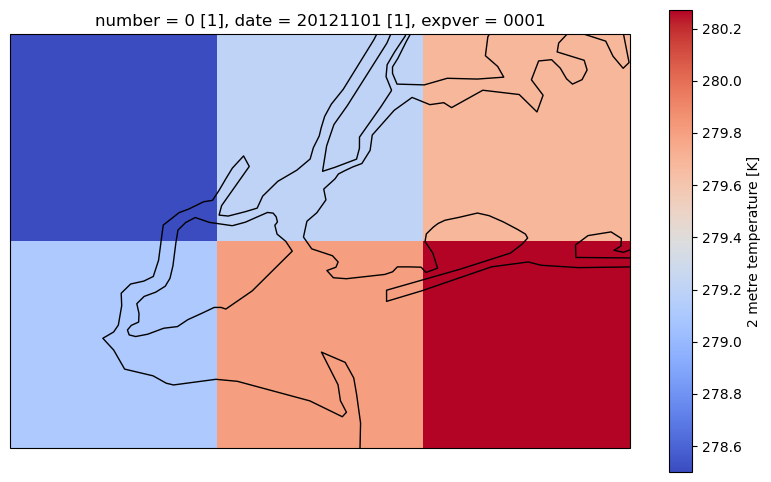

In [417]:
fig, ax = plt.subplots(figsize= (10,6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()


ds['t2m'].isel(date=346).plot(
    ax=ax,
    x='longitude',  # Longitude coordinate
    y='latitude',  # Latitude coordinate
    cmap='coolwarm',
)

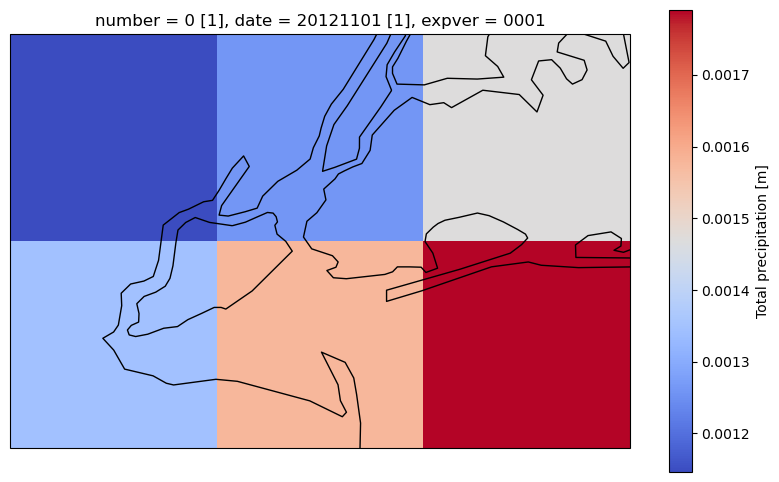

In [418]:
#sandy = 20121101

fig, ax = plt.subplots(figsize= (10,6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()


ds['tp'].isel(date=346).plot(
    ax=ax,
    x='longitude',  # Longitude coordinate
    y='latitude',  # Latitude coordinate
    cmap='coolwarm',  
)

In [6]:
nyc_avg_xr = ds.mean(dim=['latitude', 'longitude'])



In [7]:
nyc_avg = nyc_avg_xr.to_dataframe().reset_index()

In [8]:
nyc_avg['date'] = pd.to_datetime(nyc_avg['date'], format = '%Y%m%d')
nyc_avg = nyc_avg.set_index('date')

In [9]:

nyc_avg.drop(columns=['number','expver'],inplace=True)

nyc_avg = nyc_avg.rename(columns={
    'sro': 'Surface Runoff',
    'v10': '10 metre V wind component',
    'msl': 'Mean Sea Level Pressure',
    't2m': 'Temperature 2m',
    'd2m': 'Dewpoint 2m',
    'tp': 'Total Precip',
})

In [10]:
nyc_avg ## need to standardize variables


,Surface Runoff,Mean Sea Level Pressure,10 metre V wind component,Temperature 2m,Dewpoint 2m,Total Precip
date,,,,,,
1984-01-01,0.000030,102149.937500,-0.897925,270.688965,266.289337,0.001801
1984-02-01,0.001056,101510.617188,-0.227189,276.584595,272.234039,0.004898
1984-03-01,0.000523,101487.250000,-1.760850,274.949738,269.114349,0.005265
1984-04-01,0.001571,101279.382812,-0.261592,282.524323,277.047699,0.005954
1984-05-01,0.000846,101403.710938,0.597855,288.522491,282.558441,0.006380
...,...,...,...,...,...,...
2024-06-01,0.000130,101404.312500,1.143170,296.260071,289.400970,0.003126
2024-07-01,0.000019,101575.585938,1.268097,298.562408,293.397705,0.002151
2024-08-01,0.000280,101626.257812,0.426059,296.740601,291.586395,0.004262


<Axes: xlabel='Year'>

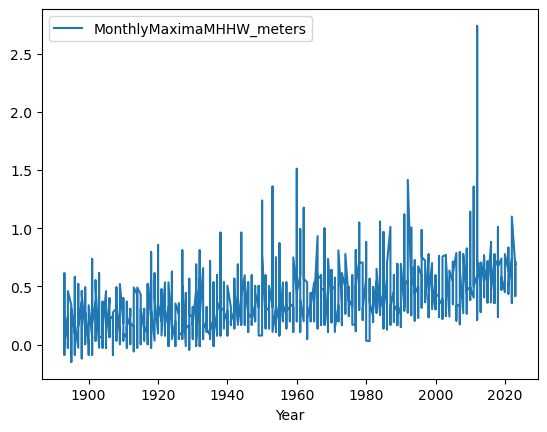

In [68]:
#import tidal gauge data max water height for battery park

##https://tidesandcurrents.noaa.gov/stationhome.html?id=8518750


tidal_gauge_data = pd.read_csv('8518750_EWL_MHHW.csv', skiprows = 5)

tidal_gauge_data.plot(x='Year', y='MonthlyMaximaMHHW_meters')


In [67]:
# Slice rows between 1994 and 2024
tidal = tidal_gauge_data[(tidal_gauge_data['Year'] >= 1984) & (tidal_gauge_data['Year'] <= 2024)]
tidal


,Year,Month,MonthlyMaximaMHHW_meters
1084,1984,Jan,0.270
1085,1984,Feb,0.429
1086,1984,Mar,1.057
1087,1984,Apr,0.566
1088,1984,May,0.316
...,...,...,...
1546,2023,Jun,0.686
1547,2023,Jul,0.514
1548,2023,Aug,0.571
1549,2023,Sep,0.637


In [13]:
nyc_avg['Year'] = nyc_avg.index.year
nyc_avg['Month'] = nyc_avg.index.month
nyc_avg.reset_index(inplace=True)

In [70]:
# Convert month names to numbers from tidal gauge
tidal['Month'] = pd.to_datetime(tidal['Month'], format='%b').dt.month

/var/folders/3h/_9j4h7zd7rz513ts0v8w3vdm0000gn/T/ipykernel_36896/3707038113.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidal['Month'] = pd.to_datetime(tidal['Month'], format='%b').dt.month


In [71]:
#merge 

nyc_merged  = pd.merge(nyc_avg, tidal, on=['Month', 'Year']) 
nyc_merged.set_index('date', inplace=True)
nyc_merged.drop(columns=['Month', 'Year'], inplace=True) #datetime

<Axes: xlabel='date'>

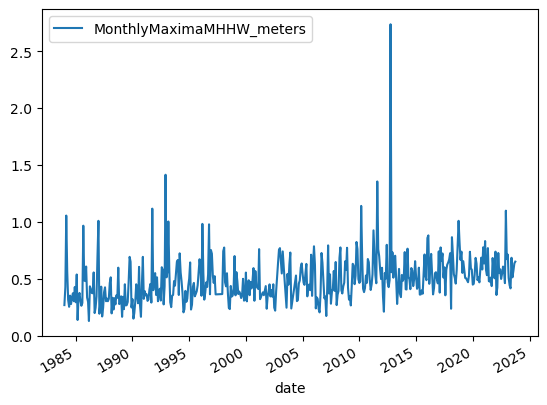

In [16]:
nyc_merged.plot(y='MonthlyMaximaMHHW_meters')

In [17]:
#standardize
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

scaler = StandardScaler()
nyc_scaled = scaler.fit_transform(nyc_merged)

In [18]:
nyc_scaled

array([[-0.67986772,  1.77964889, -1.09047016, ..., -1.56403481,
        -0.99189582, -1.06165114],
       [ 2.60451572, -0.63590654, -0.11576349, ..., -0.8793919 ,
         1.13400114, -0.31160326],
       [ 0.89908773, -0.72419521, -2.3444643 , ..., -1.23868216,
         1.38637065,  2.65084999],
       ...,
       [-0.14976156, -1.30325196,  0.70657657, ...,  1.29550811,
         0.23856535,  0.35825082],
       [ 0.47694175,  0.2352319 , -1.88076507, ...,  1.07050269,
         2.53936314,  0.66959145],
       [-0.42438405, -0.96727684, -0.29102332, ...,  0.46708724,
        -0.22864315,  0.74035068]])

In [74]:
df = pd.DataFrame(nyc_scaled, columns=nyc_merged.columns)

df.columns

X = df[['Surface Runoff',
       'Mean Sea Level Pressure', 'Temperature 2m', 'Dewpoint 2m',
       'Total Precip']]

y = df['MonthlyMaximaMHHW_meters']


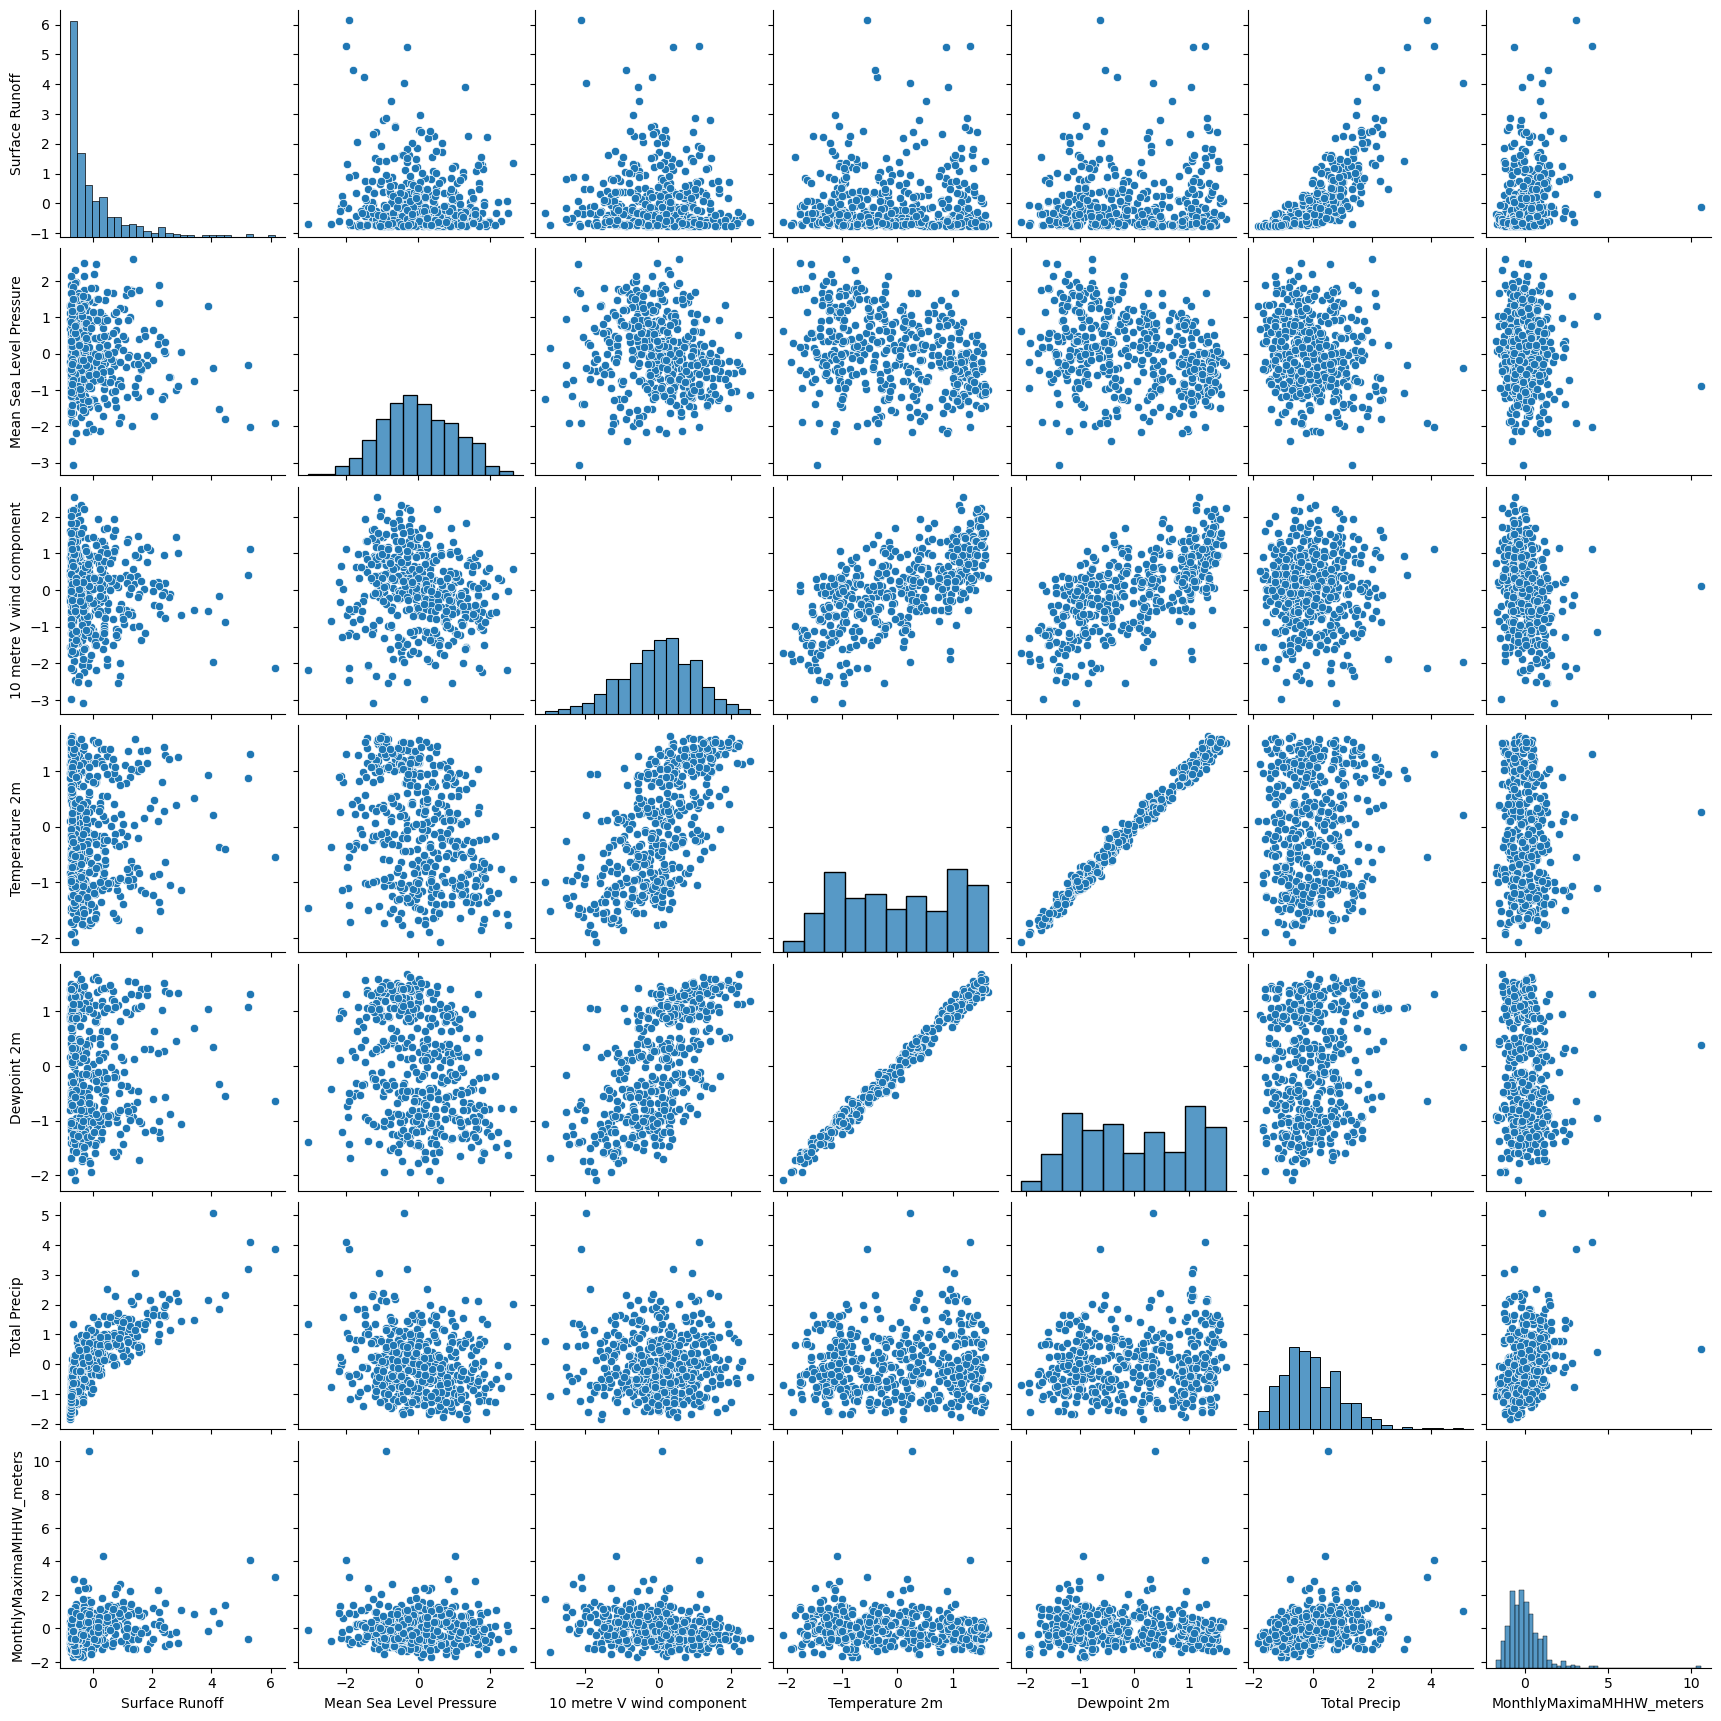

In [21]:
sb.pairplot(df)

#based on this, none of our variables seem to have much of a relationship with the y value... not looking good. 

In [75]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score, explained_variance_score
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [88]:
#use random forest model

rf = RandomForestRegressor(random_state=42, n_estimators=100) #chose this because it's multivariable, not exactly linear 

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rmse = (mean_squared_error(y_test, y_pred))**.05

print('RMSE :', rmse) #not looking great

print('Max Y Value:', y_test.max())
print('Min Y Value:', y_test.min())


#RMSE is a large % 

RMSE : 0.9765796973780789
Max Y Value: 2.938604207508626
Min Y Value: -1.6230077254085926


In [82]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

# Score is not ideal! Maybe we can optimize model with hyperparameters 

R² Score: 0.0681678805017667


In [83]:
rf_params= {'bootstrap': [True, False],  
   'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],  
   'max_features': [1, 'sqrt'],  
   'min_samples_leaf': [1, 2, 4],  
   'min_samples_split': [2, 5, 10],  
   'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [86]:
# Create grid search for LGBM model
rf_grid = RandomizedSearchCV(estimator=rf, param_distributions=rf_params, 
                                n_iter=100, verbose=2, cv=5,
                                n_jobs=-1)


In [27]:
# Fit the random search LGBM model
rf_grid.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   2.4s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   2.4s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   2.4s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   2.4s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   2.4s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   2.7s
[CV] END bootstrap=True, max_depth=80, max_features=1, min_samples_leaf=4, min_samples_split=10, n_estimators=

/Users/marygan/anaconda3/envs/ModulesEnv/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': [1, 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   verbose=2)

In [65]:
# Best parameters
print(rf_grid.best_params_)
print(rf_grid.best_score_) #that's really low!

{'n_estimators': 2000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 1, 'max_depth': 30, 'bootstrap': True}
0.06930771060423627


In [66]:
rf_best = RandomForestRegressor(n_estimators = 2000, min_samples_split = 10, min_samples_leaf = 1, max_features = 1, max_depth = 30, bootstrap = True)
rf_best.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, max_features=1, min_samples_split=10,
                      n_estimators=2000)

In [31]:
y_pred_best = rf_best.predict(X_test)

In [90]:

r2 = r2_score(y_test, y_pred_best)
rmse = mean_squared_error(y_test, y_pred_best)**.05

print(f"Test R²: {r2}")
print(f"Test RMSE: {rmse}")

Test R²: 0.0992793337510176
Test RMSE: 0.9749229946431176


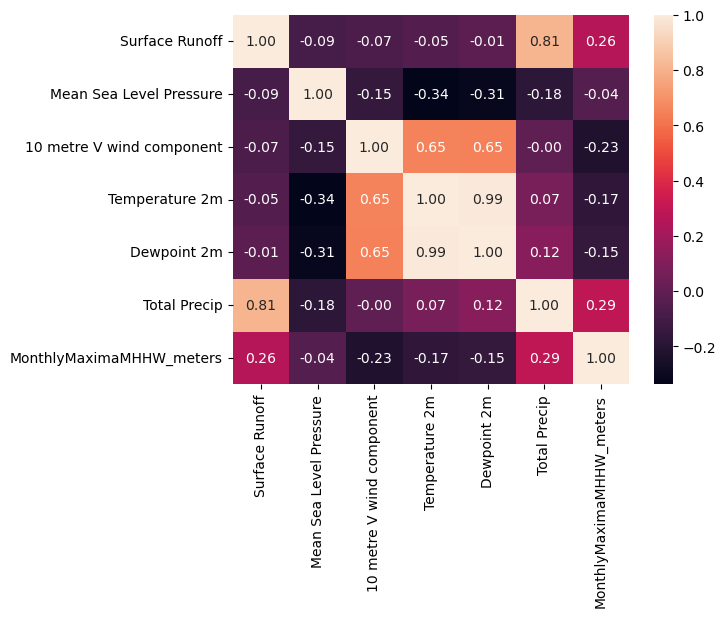

In [33]:
sb.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

### Results: Model wasn't successful. It had high RMSE and low R^2 indicating low validity. Hyperparameter optimization was not successful either. 

### Conclusion: Precipitation and storm runoff within the grid do not appear to have a significant effect on the tidal gauge data of New York City. The assumption from this current model is that it does not support that the water falling and running off from the city is necessarily related to the max tidal gauge levels. Perhaps the target variable is not the best for measuring flooding effects from precipitation, however it also doesn't seem to connect storms with lots of precipitation generally to increased tidal levels which might mean that precipitation alone is not a significant factor in major flood risk. 

### New Approach: Can we connect flood report data from individuals in the city, shown through 311 call logs, to these variables to predict community impacts? People report flooded roads and drains to 311.

In [92]:
#Because of the order limitations (1000 lines per order of data) I decided to query the data prior to downloading. API is available, however for this assignment after I downloaded it, I saved locally. 
#Queried fro "Brief Description" to contain word "flood"
floods_311 = pd.read_csv('311_Call_Center_Inquiry.csv')
floods_311

,UNIQUE_ID,DATE,TIME,DATE_TIME,AGENCY,AGENCY_NAME,INQUIRY_NAME,BRIEF_DESCRIPTION,CALL_RESOLUTION
0,100013924,03/27/2014,12:10:05 PM,03/27/2014 12:10:05 PM,DEP,Department of Environmental Protection,Flooding Street,Report street flooding.,Universal Intake SR
1,100000117,03/27/2014,5:50:15 PM,03/27/2014 05:50:15 PM,DEP,Department of Environmental Protection,Catch Basin Clogged or Blocked,Report a catch basin or storm drain that is cl...,Universal Intake SR
2,100001858,03/27/2014,6:29:05 PM,03/27/2014 06:29:05 PM,DEP,Department of Environmental Protection,Catch Basin Clogged or Blocked,Report a catch basin or storm drain that is cl...,Universal Intake SR
3,100002205,03/27/2014,2:40:19 PM,03/27/2014 02:40:19 PM,DEP,Department of Environmental Protection,Catch Basin Clogged or Blocked,Report a catch basin or storm drain that is cl...,Universal Intake SR
4,100004623,03/27/2014,1:45:08 PM,03/27/2014 01:45:08 PM,DEP,Department of Environmental Protection,Catch Basin Clogged or Blocked,Report a catch basin or storm drain that is cl...,Internal Transfer
...,...,...,...,...,...,...,...,...,...
175111,159335497,06/06/2024,6:02:30 PM,06/06/2024 06:02:30 PM,NaN,NaN,Manhole Flooding,Report a manhole that is overflowing with wate...,NaN
175112,159335597,06/06/2024,6:13:24 PM,06/06/2024 06:13:24 PM,NaN,NaN,Street Flooding,Report street flooding or ponding.,NaN
175113,159336087,06/06/2024,7:04:03 PM,06/06/2024 07:04:03 PM,NaN,NaN,Street Flooding,Report street flooding or ponding.,NaN
175114,159336258,06/06/2024,7:20:34 PM,06/06/2024 07:20:34 PM,NaN,NaN,Street Flooding,Report street flooding or ponding.,NaN


In [93]:
floods_311.drop(columns = ['DATE', 'TIME','UNIQUE_ID','AGENCY','AGENCY_NAME', 'CALL_RESOLUTION', 'BRIEF_DESCRIPTION'], inplace = True)
floods_311['DATE_TIME'] = pd.to_datetime(floods_311['DATE_TIME'])
floods_311.set_index('DATE_TIME', inplace=True)

floods_311['Year'] = floods_311.index.year
floods_311['Month'] = floods_311.index.month

In [94]:
grouped = floods_311.groupby(['Year','Month']).count()

grouped.rename(columns={'INQUIRY_NAME':'Flood Related Calls'}, inplace =True)

grouped

Flood Related Calls
Year Month                     
2010 1                      234
     2                      342
     3                      898
     4                      207
     5                      258
...                         ...
2024 7                      234
     8                      372
     9                      205
     10                     163
     11                      84

[179 rows x 1 columns]

<Axes: xlabel='date'>

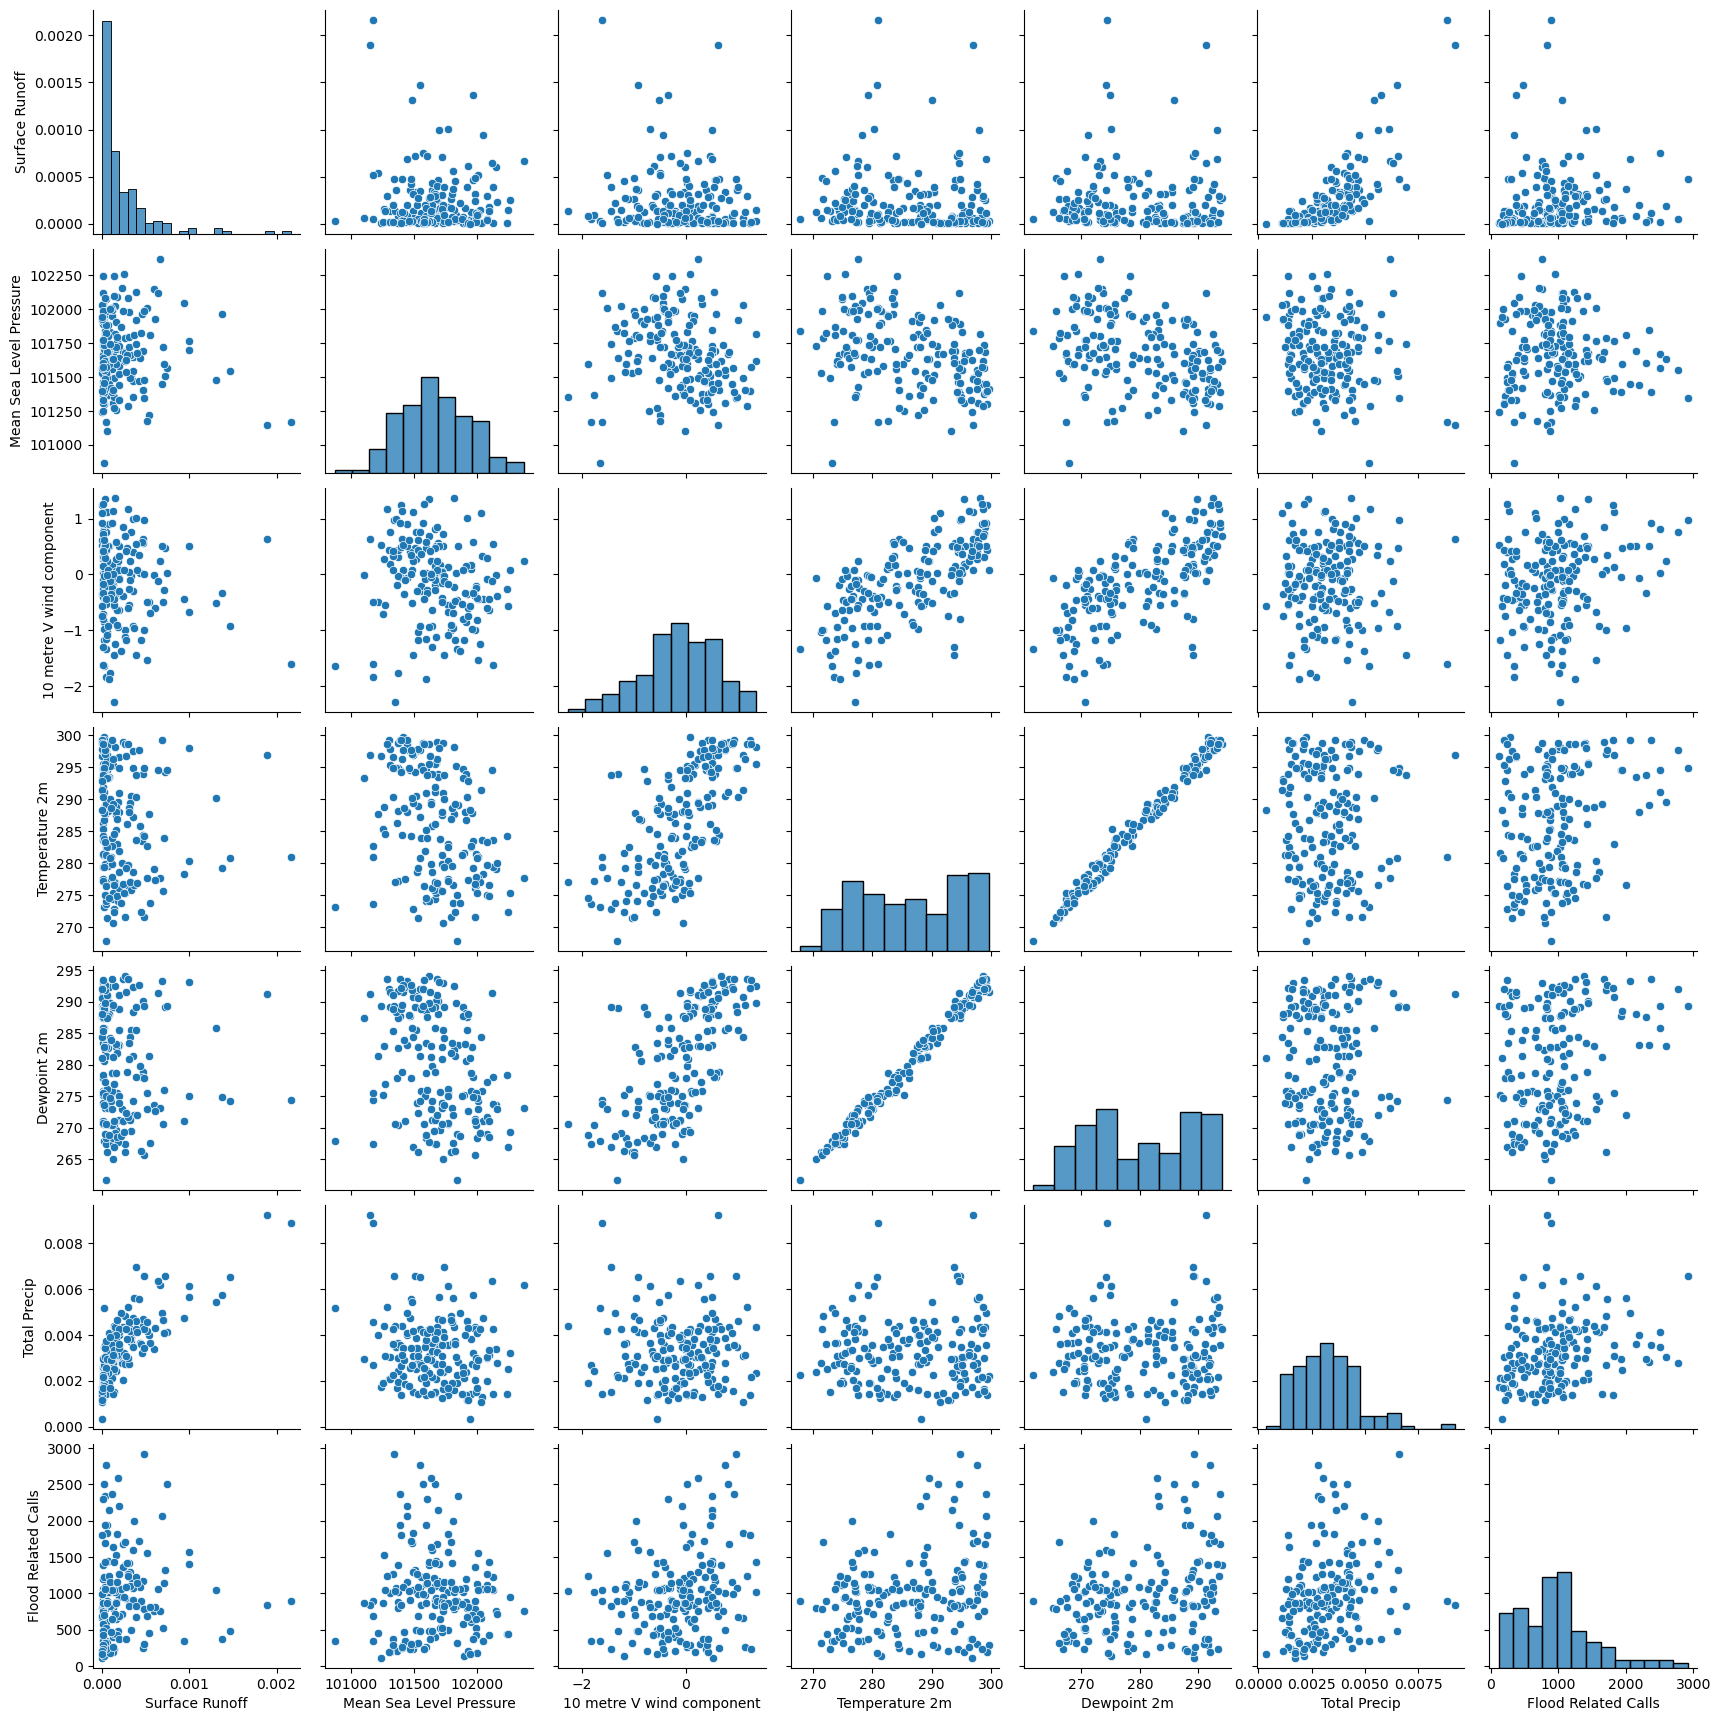

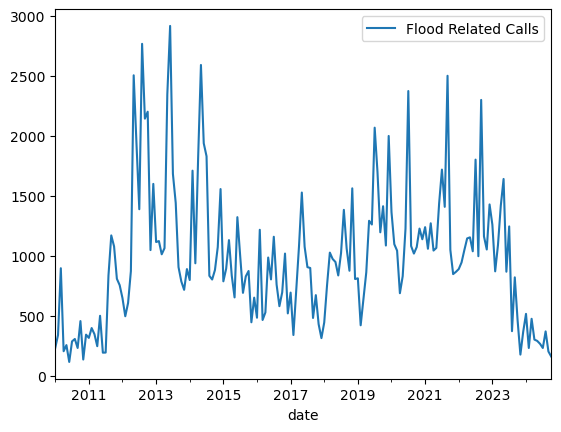

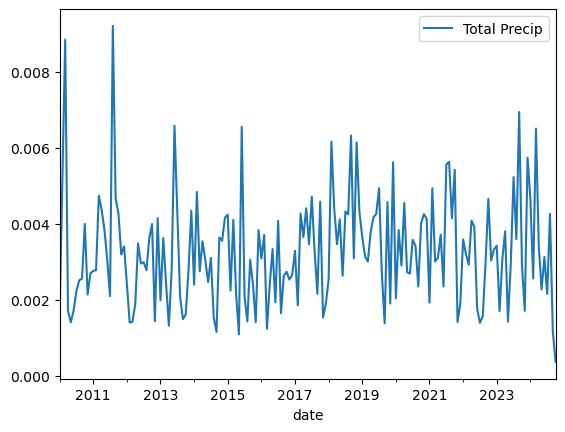

In [97]:
nyc_merged_flood = pd.merge(nyc_avg, grouped, on = ['Year', 'Month'])
nyc_merged_flood= nyc_merged_flood.drop(columns={'Year','Month'})

nyc_merged_flood = nyc_merged_flood.set_index('date')

sb.pairplot(nyc_merged_flood)
nyc_merged_flood.plot(use_index=True, y='Flood Related Calls')
nyc_merged_flood.plot(use_index=True, y='Total Precip')

In [98]:
y = nyc_merged_flood['Flood Related Calls']

In [99]:
nyc_scale_flood = scaler.fit_transform(nyc_merged_flood)
nyc_scale_flood

df_flood = pd.DataFrame(nyc_scale_flood, columns=nyc_merged_flood.columns, index=nyc_merged_flood.index)

X = df_flood[['Surface Runoff', 'Mean Sea Level Pressure',
       '10 metre V wind component', 'Temperature 2m', 'Dewpoint 2m',
       'Total Precip']]



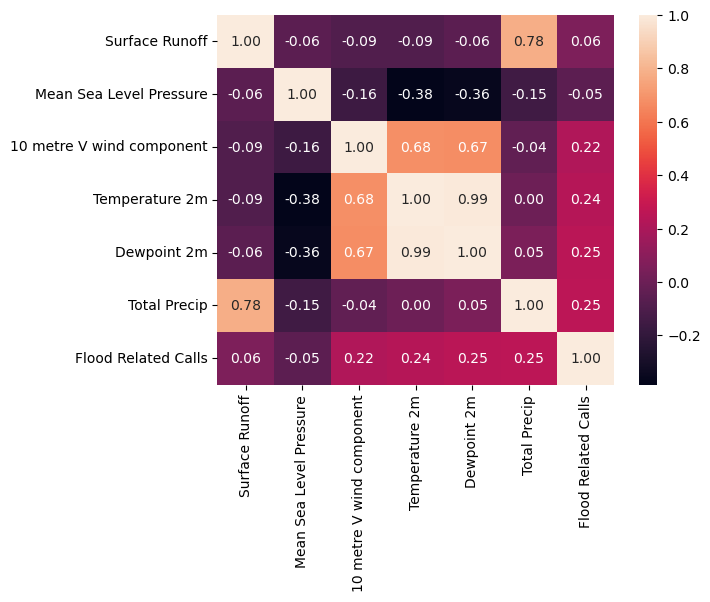

In [63]:
sb.heatmap(nyc_merged_flood.corr(), annot=True, fmt=".2f")
plt.show()

In [102]:
#use random forest model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state=2, n_estimators=100) #chose this because it's multivariable, not exactly linear 

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rmse = (mean_squared_error(y_test, y_pred))**.05

print('RMSE :', rmse) #not looking great

print('Max Y Value:', y_test.max())
print('Min Y Value:', y_test.min())

print('R^2', r2_score(y_test, y_pred))



RMSE : 1.9093935176679182
Max Y Value: 2915
Min Y Value: 196
R^2 0.17002289065569032


<Axes: title={'center': 'New York City Monthly Flood Related 311 Calls vs Monthly Total Precipitation'}, xlabel='date'>

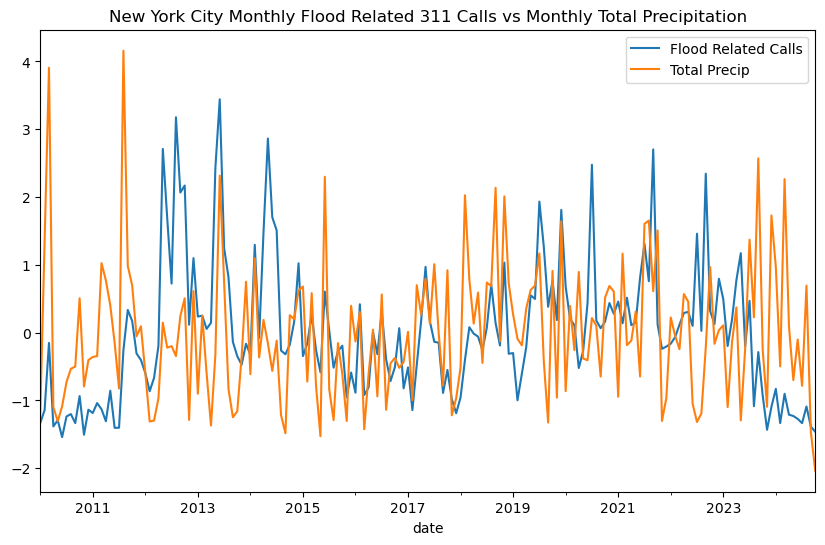

In [108]:
fig, ax = plt.subplots(figsize= (10,6))
ax.set_title('New York City Monthly Flood Related 311 Calls vs Monthly Total Precipitation')
df_flood.plot(use_index=True, y='Flood Related Calls', ax=ax)
df_flood.plot(use_index=True, y='Total Precip', ax=ax)

#look at the difference between Hurricane Irene (2011) and Superstorm Sandy (2012). Irene brought signficantly more precipitation than Sandy, but resulted in far fewer calls.

## Superstorm Sandy (Image 1) vs Hurricane Irene (Image 2) Storm Paths

IMAGE SOURCE: NOAA

![alt text](image-1.png)

![alt text](image.png)

## Conclusions

1. Are these the best variables to be using? Are these the best target variables to assess flooding? 

- Tidal gauge data is measuring the sea level off the coast. While high precipitation and runoff could correlate to high rates of flooding, it doesn't necessarily mean that it would show the same way on the tidal gauge. Infrastructure flooding doesn't always mean that ocean levels are rising because it may be contingent on the drainage systems of an area. Furthermore, the data likely isn't account for more variables related to storm surge, which can heavily influence water levels. 

- When evaluating the 311 data, it was clear that calls and total precipitation were correlated somewhat, but not enough that it could account for the fluctuations. 

- Reviewing the timeframe of Hurricane Sandy and Hurricane Irene against our data, we can see that although Sandy was a costlier disaster than Irene, Irene's impacts were not as widespread as Sandy's. This could be attributed to the direction of the storm since Irene came from the south and Sandy came from the east. 

- It could be that NYC's capacity and resiliency against high levels of precipitation are greater than for storm surge and that we need to be assessing for different types of flooding (storm surge vs precipitation based)